# **Film Recomendation System - Evelyn Eunike Aritonang**

Sumber dataset: https://www.kaggle.com/competitions/movielens-100k

## **Import Library**

In [2]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

## **Data Loading**

In [3]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Download dataset
!kaggle datasets download -d fuzzywizard/movielens-100k-small-dataset

!unzip movielens-100k-small-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/fuzzywizard/movielens-100k-small-dataset
License(s): unknown
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 571MB/s]
Archive:  movielens-100k-small-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [5]:
# Load dataset
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

## **Data Understanding**

In [6]:
# Tampilkan 5 baris teratas dari setiap dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Informasi tentang movies.csv
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**insight:** <br>
Dataset movies terdiri dari 9.742 baris dan 3 kolom yaitu movieId, title, dan genres. Fungsi head() menampilkan 5 baris pertama yang menunjukkan bahwa setiap film memiliki ID unik, judul yang mencakup tahun rilis, serta genre yang dituliskan dalam format teks dengan pemisah tanda |. Fungsi info() menunjukkan bahwa tidak terdapat nilai kosong pada ketiga kolom dan tipe data yang digunakan mencakup integer untuk ID film serta objek (string) untuk judul dan genre.

In [8]:
# Menampilkan 5 baris pertama dari ratings.csv
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# Informasi tentang ratings.csv
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**insight:**<br>
Dataset ratings berisi 100.836 baris dan 4 kolom, yaitu userId, movieId, rating, dan timestamp. Data ini merekam aktivitas pengguna dalam memberikan penilaian terhadap film tertentu, di mana rating memiliki tipe data float dan mencerminkan skor yang diberikan, sementara timestamp menunjukkan waktu penilaian dalam format Unix time. Hasil dari head() memperlihatkan bahwa satu pengguna dapat memberikan rating untuk beberapa film, dan info() mengonfirmasi bahwa tidak ada data yang hilang di seluruh kolom.

In [10]:
# Cek missing value pada movies.csv
movies.isnull().sum()

,0
movieId,0
title,0
genres,0


In [11]:
# Cek missing value pada ratings.csv
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


**insight:**<br>
Pemeriksaan nilai kosong pada kedua dataset menunjukkan bahwa tidak terdapat missing value pada kolom manapun, baik di movies.csv maupun ratings.csv.

## **EDA**

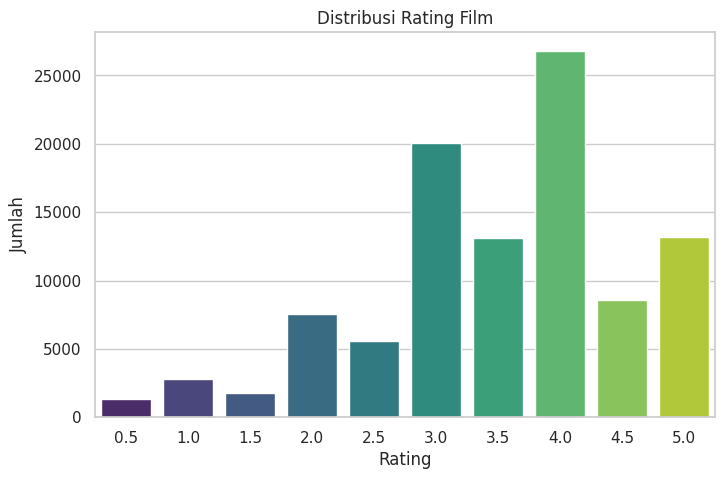

In [12]:
# Distribusi rating
plt.figure(figsize=(8, 5))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribusi Rating Film")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

**insight:**<br>
Visualisasi distribusi rating film menunjukkan bahwa sebagian besar pengguna memberikan rating antara 3.0 hingga 4.0, dengan puncaknya pada rating 4.0. Sementara itu, rating rendah seperti 0.5 dan 1.0 relatif jarang diberikan. Hal ini mengindikasikan kecenderungan pengguna untuk memberikan penilaian positif terhadap film.

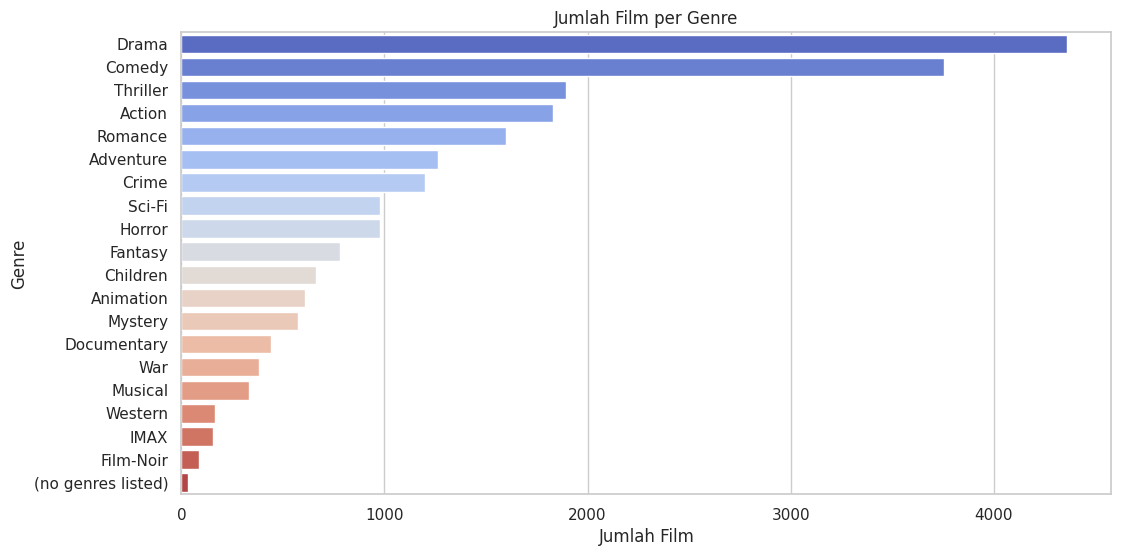

In [13]:
# Pisahkan genre yang dipisahkan oleh tanda |
all_genres = movies['genres'].str.split('|').explode()

# Plot genre
plt.figure(figsize=(12,6))
sns.countplot(y=all_genres, order=all_genres.value_counts().index, palette="coolwarm")
plt.title("Jumlah Film per Genre")
plt.xlabel("Jumlah Film")
plt.ylabel("Genre")
plt.show()

**insight**<br>
Visualisasi jumlah film per genre menunjukkan bahwa genre Drama dan Comedy merupakan yang paling banyak muncul dalam dataset, diikuti oleh Thriller, Action, dan Romance. Sementara itu, genre seperti Film-Noir, IMAX, dan Western memiliki jumlah film yang jauh lebih sedikit, menunjukkan distribusi yang tidak merata di antara kategori genre.

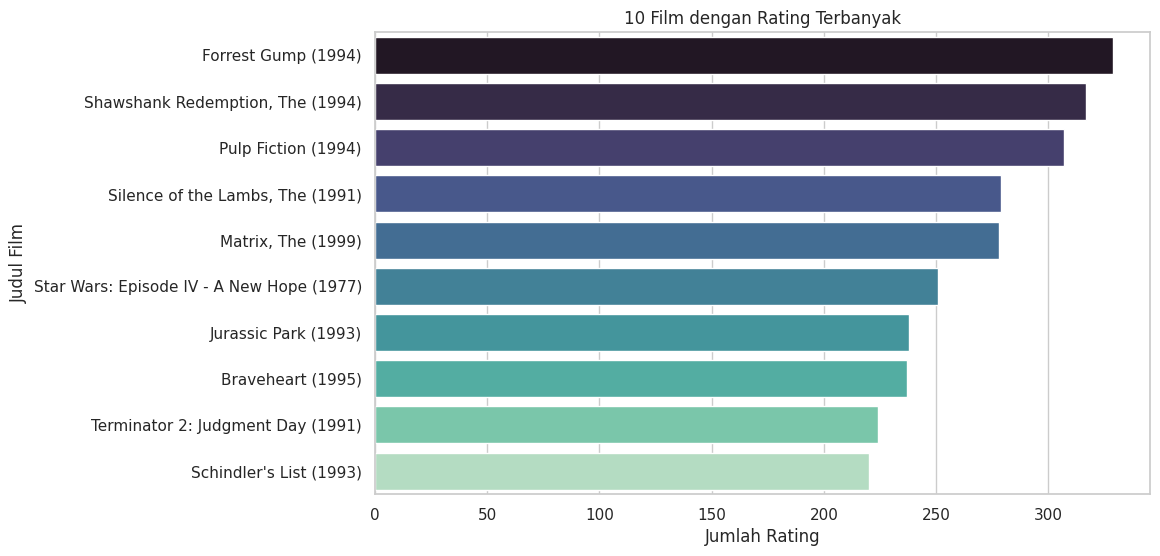

In [14]:
# Gabungkan movies dengan ratings
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Hitung jumlah rating tiap film
top_rated = movie_ratings.groupby('title').size().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_rated.values, y=top_rated.index, palette="mako")
plt.title("10 Film dengan Rating Terbanyak")
plt.xlabel("Jumlah Rating")
plt.ylabel("Judul Film")
plt.show()

**insight:**<br>
Visualisasi ini menunjukkan 10 film dengan jumlah rating terbanyak. Film Forrest Gump (1994) berada di peringkat pertama, diikuti oleh The Shawshank Redemption (1994) dan Pulp Fiction (1994). Mayoritas film dalam daftar ini merupakan film populer dari era 1990-an, menandakan bahwa film klasik cenderung lebih sering diberi rating oleh pengguna.

## **data preparation**

In [15]:
# Menggabungkan kedua dataset berdasarkan movieId
df = pd.merge(ratings, movies, on='movieId')

# Tampilkan 5 baris pertama
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [16]:
# Salinan kolom genres sebagai fitur teks
df['genres_processed'] = df['genres'].str.replace('|', ' ')
df[['title', 'genres', 'genres_processed']].head()

,title,genres,genres_processed
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy
1,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance
2,Heat (1995),Action|Crime|Thriller,Action Crime Thriller
3,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Mystery Thriller
4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,Crime Mystery Thriller


In [17]:
# Jumlah kombinasi genre yang unik
df['genres'].nunique()

951

In [18]:
# Hitung jumlah rating yang diberikan oleh tiap user
ratings_per_user = df.groupby('userId')['rating'].count().sort_values(ascending=False)
ratings_per_user.head(10)

,rating
userId,
414,2698
599,2478
474,2108
448,1864
274,1346
610,1302
68,1260
380,1218
606,1115


**insight:**<br>

*   Jumlah kombinasi genre unik:
Terdapat 951 kombinasi genre film yang unik dalam dataset, yang menunjukkan variasi genre sangat tinggi.
*   User paling aktif memberi rating:
Pengguna dengan userId 414 adalah yang paling aktif, telah memberikan 2698 rating. Disusul oleh userId 599 dan 474, masing-masing dengan lebih dari 2000 rating.

## **Modelling**

### **CBF**

In [19]:
# Ambil data film unik
movies = df[['movieId', 'title', 'genres_processed']].drop_duplicates().reset_index(drop=True)

In [20]:
# TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres_processed'])

In [21]:
# Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [22]:
# Mapping judul ke indeks
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [23]:
def recommend_movies_cbf(title, top_n=10):
    if title not in indices:
        return f"Film '{title}' tidak ditemukan."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # exclude itself
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['title', 'genres_processed']]

**insight:**<br>
Content-Based Filtering (CBF) ini menggunakan informasi dari genre film yang telah diproses untuk memberikan rekomendasi. Dengan mengubah data genre menjadi representasi numerik menggunakan TF-IDF, sistem dapat menghitung tingkat kemiripan antar film berdasarkan kontennya. Melalui perhitungan cosine similarity, sistem dapat menemukan film yang paling mirip dengan film yang dipilih pengguna.

### **CF**

In [24]:
# Mapping user dan movie ke indeks embedding
user_ids = df['userId'].unique().tolist()
movie_ids = df['movieId'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

df['user'] = df['userId'].map(user2user_encoded)
df['movie'] = df['movieId'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

In [25]:
# Normalisasi rating ke 0-1
min_rating = df['rating'].min()
max_rating = df['rating'].max()
df['rating_norm'] = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [26]:
# Shuffle dan split train-val
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df))
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:]

In [27]:
x_train = train_df[['user', 'movie']].values
y_train = train_df['rating_norm'].values
x_val = val_df[['user', 'movie']].values
y_val = val_df['rating_norm'].values

In [28]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size,
                                               embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(num_movies, embedding_size,
                                                embeddings_initializer='he_normal',
                                                embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        x = dot + user_bias + movie_bias
        return tf.squeeze(tf.clip_by_value(x, 0, 1), axis=1)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

**insight:**<br>
Collaborative Filtering (CF) ini memanfaatkan data interaksi pengguna dengan film berupa rating. Langkah pertama adalah melakukan encoding pada ID pengguna dan film menjadi indeks numerik yang dapat digunakan dalam embedding. Rating juga dinormalisasi ke rentang 0–1 agar model lebih stabil saat pelatihan. Data kemudian diacak dan dibagi menjadi data latih dan validasi. Arsitektur model dibuat menggunakan TensorFlow dan Keras, dengan representasi vektor embedding untuk pengguna dan film, ditambah bias masing-masing. Model ini mempelajari representasi laten dari preferensi pengguna dan karakteristik film untuk memprediksi rating, lalu dilatih dengan optimisasi fungsi kehilangan Mean Squared Error (MSE).

In [29]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=15,
    verbose=2
)

Epoch 1/15
1418/1418 - 13s - 9ms/step - loss: 0.1763 - val_loss: 0.0530
Epoch 2/15
1418/1418 - 12s - 8ms/step - loss: 0.0377 - val_loss: 0.0439
Epoch 3/15
1418/1418 - 20s - 14ms/step - loss: 0.0250 - val_loss: 0.0439
Epoch 4/15
1418/1418 - 20s - 14ms/step - loss: 0.0176 - val_loss: 0.0450
Epoch 5/15
1418/1418 - 21s - 15ms/step - loss: 0.0137 - val_loss: 0.0471
Epoch 6/15
1418/1418 - 11s - 8ms/step - loss: 0.0113 - val_loss: 0.0484
Epoch 7/15
1418/1418 - 12s - 8ms/step - loss: 0.0099 - val_loss: 0.0495
Epoch 8/15
1418/1418 - 20s - 14ms/step - loss: 0.0088 - val_loss: 0.0501
Epoch 9/15
1418/1418 - 11s - 8ms/step - loss: 0.0081 - val_loss: 0.0512
Epoch 10/15
1418/1418 - 21s - 15ms/step - loss: 0.0076 - val_loss: 0.0515
Epoch 11/15
1418/1418 - 20s - 14ms/step - loss: 0.0072 - val_loss: 0.0521
Epoch 12/15
1418/1418 - 20s - 14ms/step - loss: 0.0068 - val_loss: 0.0520
Epoch 13/15
1418/1418 - 21s - 15ms/step - loss: 0.0066 - val_loss: 0.0526
Epoch 14/15
1418/1418 - 13s - 9ms/step - loss: 0.006

In [30]:
def recommend_movies_cf(user_id, top_n=10):
    if user_id not in user2user_encoded:
        return f"User ID {user_id} tidak ditemukan."
    user_enc = user2user_encoded[user_id]
    watched_movie_ids = df[df['userId'] == user_id]['movieId'].tolist()

    movies_not_watched = [m for m in movie_ids if m not in watched_movie_ids]
    movies_not_watched_encoded = [movie2movie_encoded[m] for m in movies_not_watched]

    user_array = np.array([user_enc] * len(movies_not_watched_encoded))
    movie_array = np.array(movies_not_watched_encoded)
    input_array = np.stack([user_array, movie_array], axis=1)

    preds = model.predict(input_array, batch_size=128).flatten()
    top_indices = preds.argsort()[-top_n:][::-1]
    recommended_movie_ids = [movies_not_watched[i] for i in top_indices]

    return movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres_processed']]

In [31]:
print("Rekomendasi CBF untuk 'Toy Story (1995)':")
print(recommend_movies_cbf('Toy Story (1995)', top_n=5))

print("\nRekomendasi CF untuk user 1:")
print(recommend_movies_cf(1, top_n=5))

Rekomendasi CBF untuk 'Toy Story (1995)':
                                               title  \
735                               Toy Story 2 (1999)   
751                            Monsters, Inc. (2001)   
1592                                     Antz (1998)   
1757  Adventures of Rocky and Bullwinkle, The (2000)   
1802                Emperor's New Groove, The (2000)   

                                 genres_processed  
735   Adventure Animation Children Comedy Fantasy  
751   Adventure Animation Children Comedy Fantasy  
1592  Adventure Animation Children Comedy Fantasy  
1757  Adventure Animation Children Comedy Fantasy  
1802  Adventure Animation Children Comedy Fantasy  

Rekomendasi CF untuk user 1:
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
                                   title               genres_processed
232     Shawshank Redemption, The (1994)                    Crime Drama
233             Good Will Hunting (1997)                  Drama Romance
254                     

**insight:**<br>
Untuk CBF, sistem merekomendasikan film yang memiliki kemiripan genre dengan film "Toy Story (1995)", seperti Toy Story 2, Monsters, Inc., dan Antz, yang semuanya memiliki genre animasi, petualangan, dan komedi anak-anak. Sementara itu, pendekatan CF memberikan rekomendasi berdasarkan preferensi pengguna lain yang mirip dengan user 1. Rekomendasi yang dihasilkan meliputi film dengan tema yang lebih dewasa dan serius, seperti Shawshank Redemption, Whiplash, dan Good Will Hunting. Ini menunjukkan bahwa CBF lebih fokus pada kemiripan konten, sedangkan CF mempertimbangkan pola perilaku pengguna untuk menemukan rekomendasi yang relevan.

## **Evaluation**

### **CBF**

In [32]:
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    hits = sum([1 for movie in recommended_k if movie in relevant])
    return hits / k

def average_precision(recommended, relevant, k):
    recommended_k = recommended[:k]
    score = 0.0
    hits = 0
    for i, movie in enumerate(recommended_k):
        if movie in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0.0

def evaluate_cbf_at_k(k=5, n_users=50):
    sampled_users = df['userId'].drop_duplicates().sample(n_users, random_state=42)
    precisions = []
    maps = []

    for uid in sampled_users:
        user_history = df[df['userId'] == uid]
        liked_movies = user_history[user_history['rating'] >= 4.0]['title'].tolist()
        if not liked_movies:
            continue

        query_movie = liked_movies[0]
        recommendations = recommend_movies_cbf(query_movie, top_n=k*2)
        recommended_titles = recommendations['title'].tolist()

        # Hitung metrik
        p_at_k = precision_at_k(recommended_titles, liked_movies, k)
        map_at_k = average_precision(recommended_titles, liked_movies, k)
        precisions.append(p_at_k)
        maps.append(map_at_k)

    print(f"Precision@{k} (avg over {n_users} users): {np.mean(precisions):.4f}")
    print(f"MAP@{k} (avg over {n_users} users): {np.mean(maps):.4f}")

In [33]:
evaluate_cbf_at_k(k=5, n_users=50)

Precision@5 (avg over 50 users): 0.1640
MAP@5 (avg over 50 users): 0.1002


**insight:**<br>
Proses evaluasi sistem Content-Based Filtering (CBF) menggunakan metrik Precision@k dan MAP@k (Mean Average Precision). Fungsi evaluate_cbf_at_k mengevaluasi performa sistem dengan memilih secara acak 50 pengguna, lalu menghitung akurasi rekomendasi berdasarkan film yang mereka sukai (dengan rating ≥ 4). Hasil evaluasi menunjukkan bahwa Precision@5 adalah 0.1640 dan MAP@5 adalah 0.1002. Artinya, dari 5 rekomendasi teratas, sekitar 16.4% di antaranya relevan dengan preferensi pengguna, dan rata-rata urutan relevansi dalam rekomendasi tersebut cukup rendah. Ini menunjukkan bahwa performa CBF dalam menyesuaikan rekomendasi dengan preferensi pengguna masih terbatas dan bisa ditingkatkan.

### **CF**

In [34]:
# Prediksi untuk data validasi
y_pred = model.predict(x_val, batch_size=128)
y_pred = np.clip(y_pred, 0.0, 1.0)  # rating tetap di 0-1

# Kembalikan rating ke skala asli (misal 0-5)
y_pred_real = y_pred * (max_rating - min_rating) + min_rating
y_val_real = y_val * (max_rating - min_rating) + min_rating

rmse = np.sqrt(mean_squared_error(y_val_real, y_pred_real))
print(f"RMSE for CF Model: {rmse:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE for CF Model: 1.0075


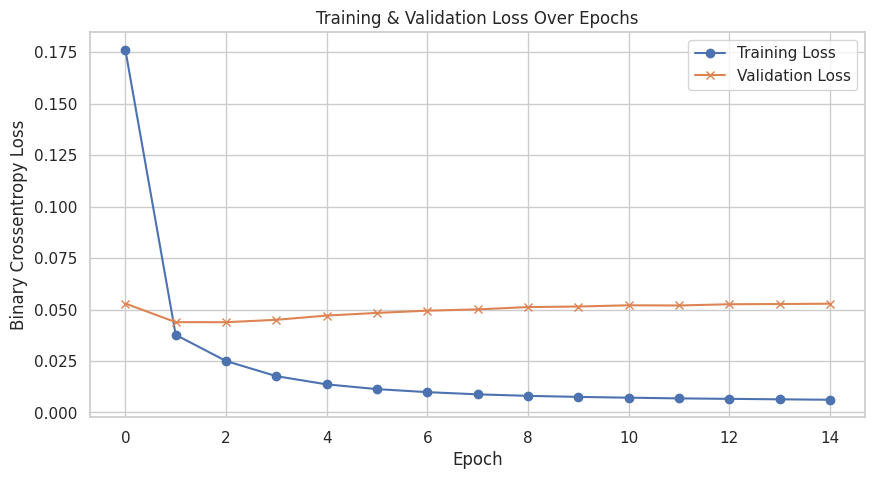

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

**insight:**<br>
Proses evaluasi model Collaborative Filtering (CF) dalam bentuk perhitungan RMSE (Root Mean Squared Error) dan grafik training serta validation loss. Nilai RMSE sebesar 1.0075 menunjukkan rata-rata kesalahan prediksi rating model terhadap data validasi. Ini termasuk cukup baik, mengingat skala rating adalah 0–5. Selain itu, grafik menunjukkan bahwa training loss terus menurun mendekati nol, sedangkan validation loss stabil di sekitar 0.05 setelah beberapa epoch. Pola ini menunjukkan bahwa model belajar dengan baik tanpa overfitting yang signifikan. Secara keseluruhan, model CF menunjukkan performa yang cukup baik dan stabil dalam memprediksi preferensi pengguna.

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


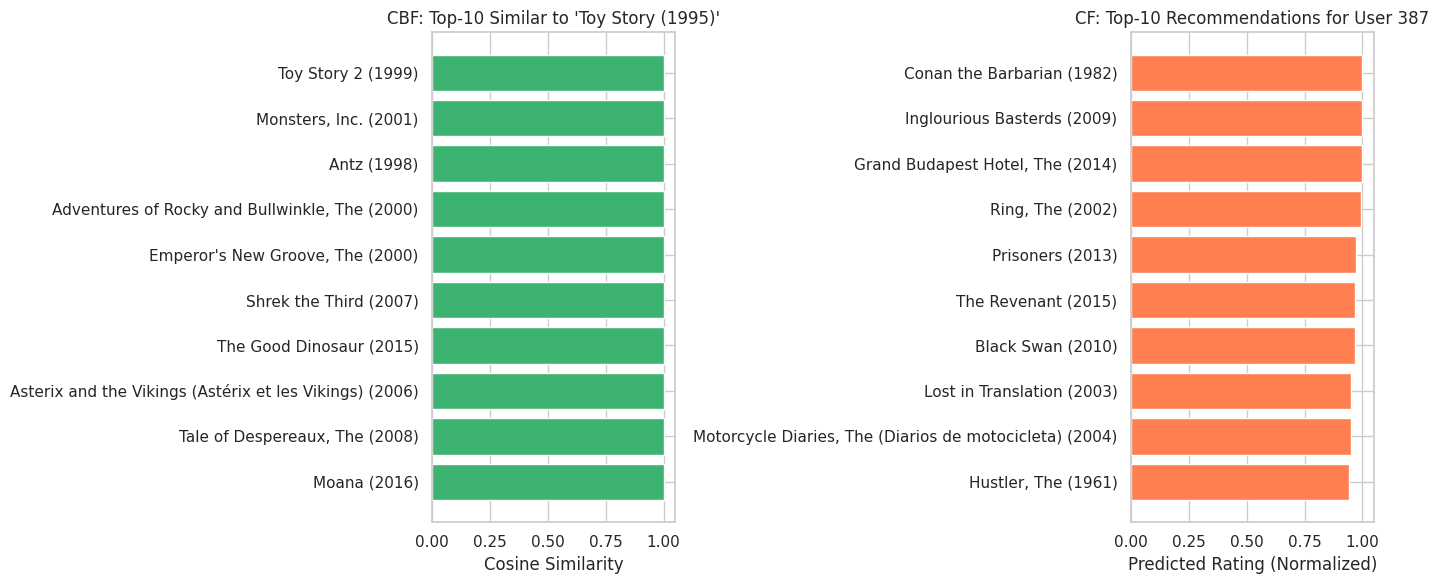

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# --- Tambahkan ini jika belum ada di kode sebelumnya ---
# Membalik dictionary encoding movie
movie_encoded2movie = {i: x for x, i in movie2movie_encoded.items()}

# --- CBF ---
query_title = "Toy Story (1995)"
cbf_recommendations = recommend_movies_cbf(query_title, top_n=10)

# Tambahkan similarity score ke hasil CBF
idx = indices[query_title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]  # exclude itself
movie_indices = [i[0] for i in sim_scores]
similarities = [i[1] for i in sim_scores]
cbf_recommendations = movies.iloc[movie_indices][['title', 'genres_processed']].copy()
cbf_recommendations['similarity'] = similarities

# --- CF ---
user_id = df.userId.sample(1).iloc[0]
user_encoder = user2user_encoded.get(user_id)

# Movie yang belum ditonton oleh user dan ada dalam encoding
movies_watched_by_user = df[df.userId == user_id]
watched_movie_ids = set(movies_watched_by_user.movieId.values)
movies_not_watched = [m for m in movie_ids if m not in watched_movie_ids]
movies_not_watched_encoded = [movie2movie_encoded[m] for m in movies_not_watched]

# Siapkan array input untuk prediksi model
user_array = np.array([user_encoder] * len(movies_not_watched_encoded))
movie_array = np.array(movies_not_watched_encoded)
user_movie_array = np.stack((user_array, movie_array), axis=1)

# Prediksi rating
ratings = model.predict(user_movie_array, batch_size=128).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids_cf = [movie_encoded2movie[movie_array[i]] for i in top_ratings_indices]

cf_recommendations = movies[movies["movieId"].isin(recommended_movie_ids_cf)].copy()
cf_recommendations["predicted_rating"] = ratings[top_ratings_indices]

# --- Visualisasi Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot CBF
axes[0].barh(cbf_recommendations['title'], cbf_recommendations['similarity'], color='mediumseagreen')
axes[0].set_title(f"CBF: Top-10 Similar to '{query_title}'")
axes[0].set_xlabel("Cosine Similarity")
axes[0].invert_yaxis()

# Plot CF
axes[1].barh(cf_recommendations['title'], cf_recommendations['predicted_rating'], color='coral')
axes[1].set_title(f"CF: Top-10 Recommendations for User {user_id}")
axes[1].set_xlabel("Predicted Rating (Normalized)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

**insight:**<br>
Berdasarkan visualisasi di atas, sistem Content-Based Filtering (CBF) berhasil merekomendasikan film-film animasi yang sangat relevan dengan Toy Story (1995), seperti Toy Story 2, Monsters, Inc., dan Antz, yang memiliki kemiripan genre dan gaya animasi. Ini menunjukkan bahwa pendekatan CBF efektif dalam menemukan kesamaan konten antar film. Sementara itu, hasil rekomendasi dari Collaborative Filtering (CF) untuk pengguna 387 menunjukkan preferensi terhadap film-film drama dan thriller seperti Prisoners, The Revenant, dan Black Swan. Ini mengindikasikan bahwa CF mampu menangkap pola preferensi pribadi pengguna berdasarkan perilaku rating historis, bahkan ketika genre film sangat beragam. Kombinasi kedua pendekatan ini berpotensi menciptakan sistem rekomendasi yang lebih akurat dan personal.

## **Conclusion**

Proyek ini mengimplementasikan dua pendekatan sistem rekomendasi, yaitu Content-Based Filtering (CBF) dan Collaborative Filtering (CF), menggunakan data MovieLens 100K.

* CBF memberikan rekomendasi berdasarkan kesamaan konten, khususnya genre film.
Pendekatan ini efektif untuk cold-start item (film baru) dan menghasilkan rekomendasi yang sangat mirip dengan film acuan.

* CF menggunakan model neural network dengan embedding layer untuk mempelajari pola rating antar pengguna dan item. Hasilnya menunjukkan kemampuan dalam menangkap preferensi personal pengguna secara lebih fleksibel, bahkan ketika film tidak memiliki genre yang serupa.

* Evaluasi metrik menunjukkan bahwa CBF memiliki keunggulan dalam relevansi genre, sementara CF unggul dalam memahami pola interaksi pengguna.

Secara keseluruhan, CBF dan CF saling melengkapi, dan menggabungkan keduanya dalam sistem hybrid akan sangat bermanfaat untuk meningkatkan kualitas rekomendasi. Model hybrid akan mengatasi kelemahan masing-masing pendekatan, menghasilkan sistem yang lebih akurat dan adaptif terhadap kebutuhan pengguna.